In [32]:
import pandas as pd
import os

In [33]:
season = pd.read_csv('NSL_regular_season_data_2.csv')
season = season.reset_index(drop=True)

In [34]:
# Assuming season is already sorted by game_id
total_games = season.shape[0]
split_index = int(total_games * 756/952)  # Aprox. 79% split (so every team plays ~27 games in training data)
# Split the dataset
season_X = season.iloc[:split_index].copy()
season_y = season.iloc[split_index:].copy()


In [35]:
all_teams = list(set(season_X["HomeTeam"]).union(set(season_X["AwayTeam"])))
ratings = {team: 1500 for team in all_teams}

In [36]:

# Initialize team ratings for both models
teams = pd.concat([season['HomeTeam'], season['AwayTeam']]).unique()
ratings_forward = {team: 1500 for team in teams}
ratings_reverse = {team: 1500 for team in teams}

# Home field advantage constant
HOME_ADVANTAGE = 100

# Elo rating function with home field advantage and xG difference
def update_elo(home_team, away_team, home_score, away_score, home_xG, away_xG, K, c):
    # Adjust home team rating for home advantage
    adjusted_home_rating = ratings[home_team] + HOME_ADVANTAGE
    
    # Calculate expected scores
    E_home = 1 / (1 + 10 ** ((ratings[away_team] - adjusted_home_rating) / c))
    E_away = 1 - E_home

    # Determine actual score
    S_home, S_away = (1, 0) if home_xG > away_xG else (0, 1) if home_xG < away_xG else (0.5, 0.5)
    
    # Calculate xG difference and adjust K factor
    xG_diff = home_xG - away_xG
    K_adjusted = K * (1 + abs(xG_diff) / 2)  # Example adjustment, modify as needed
    
    # Update ratings
    ratings[home_team] += K_adjusted * (S_home - E_home)
    ratings[away_team] += K_adjusted * (S_away - E_away)


# Update ratings_forward with the forward iteration
ratings = ratings_forward
for index, row in season.iterrows():
    update_elo(row['HomeTeam'], row['AwayTeam'], row['HomeScore'], row['AwayScore'], row['Home_xG'], row['Away_xG'], 10)

# Update ratings_reverse with the reverse iteration
ratings = ratings_reverse
for index in range(season.shape[0] - 1, -1, -1):
    row = season.iloc[index]
    update_elo(row['HomeTeam'], row['AwayTeam'], row['HomeScore'], row['AwayScore'], row['Home_xG'], row['Away_xG'], 10)

# Create a DataFrame to store both sets of ratings and calculate the difference
ratings_df = pd.DataFrame(index=teams, columns=['EloRating', 'Reverse Rating', 'Difference'])
for team in teams:
    ratings_df.at[team, 'EloRating'] = ratings_forward[team]
    ratings_df.at[team, 'Reverse Rating'] = ratings_reverse[team]
    ratings_df.at[team, 'Difference'] = ratings_forward[team] - ratings_reverse[team]
    ratings_df.at[team, "team_name"] = team

# Print the DataFrame
print(ratings_df)




TypeError: update_elo() missing 1 required positional argument: 'c'

In [312]:
import numpy as np
import math
from scipy.optimize import minimize
def update_elo(home_team, away_team, home_xG, away_xG, K, c, HFA,b):
    # Adjust home team rating for home advantage
    adjusted_home_rating = ratings[home_team] + HFA
    
    E_home = 1 / (1 + 10 ** ((ratings[away_team] - adjusted_home_rating) / c))
    E_away = 1 - E_home

    S_home, S_away = (1, 0) if home_xG > away_xG else (0, 1) if home_xG < away_xG else (0.5, 0.5)
    
    xG_diff = home_xG - away_xG
    K_adjusted = K * (1 + abs(xG_diff) / b)
    
    # Update ratings
    ratings[home_team] += K_adjusted * (S_home - E_home)
    ratings[away_team] += K_adjusted * (S_away - E_away)
    squared_error = np.sqrt ((E_home - S_home) ** 2)
    #print (squared_errors)
    return squared_error

def objective_function(params, home, away, homeXG, awayXG):
    k, hfa, c, b = params
     
    squared_errors = []
    for index, row in season_X.iterrows():
        squared_errors.append( update_elo(row['HomeTeam'], row['AwayTeam'], row['Home_xG'], row['Away_xG'], k, c, hfa, b))
    return (np.mean(squared_errors))
p0 = [10, 100, 400, 2]  
bounds = [(0, 100), (0, 100),(300, 500), (0,10)]

result = minimize(objective_function, p0, args=(row['HomeTeam'], row['AwayTeam'], row['Home_xG'], row['Away_xG']),method="Nelder-Mead")


k, hfa, c, b = result.x

print("best k factor:", k)
print("best hfa factor:", hfa)
print ("best c factor:", c)
print("best b factor:", b)
print ("rmse", result.fun)


/var/folders/ww/mbrk18t13kqg1n0nk8535q440000gn/T/ipykernel_67392/715305827.py:8: RuntimeWarning: overflow encountered in scalar power
  E_home = 1 / (1 + 10 ** ((ratings[away_team] - adjusted_home_rating) / c))


best k factor: 9.296320093074655
best hfa factor: 222.58689739303236
best c factor: 32.29228319753929
best b factor: 5.006446168539377
rmse 0.28001664107779356


In [305]:
ratings = {team: 1500 for team in all_teams}
for index, row in season_y.iterrows():
    update_elo(row['HomeTeam'], row['AwayTeam'], row['Home_xG'], row['Away_xG'], k, c, hfa, b)
print (ratings)

{'TUC': 1521.9720735589165, 'FAR': 1500.0000156434055, 'MAN': 1478.3807100115002, 'ANC': 1500.000083229581, 'DOV': 1479.0677254033037, 'OAK': 1500.000013438018, 'BAK': 1490.5180132412952, 'SAS': 1500.0000082005356, 'SJU': 1500.519887891592, 'LAR': 1490.0724547243092, 'WIC': 1519.5952759391216, 'AUG': 1500.0000837838334, 'DES': 1500.0000162842578, 'ALB': 1478.7520933980775, 'LEX': 1500.000072548688, 'EUG': 1488.7539824441094, 'LRO': 1500.000037157934, 'SPR': 1521.8049513290039, 'TOL': 1551.7360527164547, 'CHM': 1500.0000623867938, 'TAC': 1499.3128923087984, 'BOI': 1500.0000149555817, 'FOR': 1500.0000211040224, 'PRO': 1500.0000282005765, 'REN': 1500.00001058065, 'SFS': 1500.0000235247287, 'MOB': 1488.9953899031193, 'JAC': 1490.5180060917924}


In [310]:
sorted_items = sorted(ratings.items(), key=lambda x: x[1], reverse=True)

top_4_keys = [item[0] for item in sorted_items[:4]]

print(top_4_keys)

['DOV', 'SAS', 'JAC', 'LRO']


In [ ]:
import pandas as pd

# Read the CSV file into a DataFrame


# Merge for home team's Elo rating
merged_df = pd.merge(season_y, ratings_df, left_on='HomeTeam', right_on='team_name', how='left')

# Merge for away team's Elo rating
merged_df = pd.merge(merged_df, ratings_df, left_on='AwayTeam', right_on='team_name', how='left', suffixes=('_home', '_away'))

# Manually rename columns to avoid conflicts
merged_df.rename(columns={'elo_rating_home': 'home_elo_rating', 'reverse_rating_home': 'home_reverse_rating', 'difference_home': 'home_difference',
                          'elo_rating_away': 'away_elo_rating', 'reverse_rating_away': 'away_reverse_rating', 'difference_away': 'away_difference'}, inplace=True)

# Drop redundant columns
#merged_df.drop(['team_name_x', 'team_name_y'], axis=1, inplace=True)


In [ ]:
print (merged_df)

          game_id HomeTeam AwayTeam  HomeScore  AwayScore  Home_xG  Away_xG  \
0   game_2023_248      DOV      SJU          3          0     1.74     1.06   
1    game_2023_17      LEX      SJU          0          0     0.49     0.28   
2   game_2023_117      CHM      SJU          3          1     1.52     0.32   
3   game_2023_337      LAR      SJU          1          0     1.51     0.49   
4   game_2023_201      MAN      SJU          3          7     1.26     2.03   
5   game_2023_315      DES      SJU          1          1     1.36     0.35   
6   game_2023_347      FAR      SJU          4          1     2.09     0.32   
7   game_2023_378      LRO      SJU          3          0     3.27     0.47   
8   game_2023_144      PRO      SJU          2          0     0.91     0.23   
9   game_2023_450      JAC      SJU          0          0     2.13     0.34   
10   game_2023_43      MOB      SJU          0          1     0.57     1.49   
11  game_2023_408      BOI      SJU          0      

In [ ]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from scipy.optimize import optimize


# Define the Elo function
def elo_function(home_rating, away_rating, K, HFA,c):
    for index, row in season.iterrows():
        update_elo(row['HomeTeam'], row['AwayTeam'], row['HomeScore'], row['AwayScore'], row['Home_xG'], row['Away_xG'], K, c)
    merged_df = pd.merge(season_y, ratings_df, left_on='HomeTeam', right_on='team_name', how='left')

    # Merge for away team's Elo rating
    merged_df = pd.merge(merged_df, ratings_df, left_on='AwayTeam', right_on='team_name', how='left', suffixes=('_home', '_away'))

    # Manually rename columns to avoid conflicts
    merged_df.rename(columns={'elo_rating_home': 'home_elo_rating', 'reverse_rating_home': 'home_reverse_rating', 'difference_home': 'home_difference',
                            'elo_rating_away': 'away_elo_rating', 'reverse_rating_away': 'away_reverse_rating', 'difference_away': 'away_difference'}, inplace=True)
    odds = 1 / (1 + 10 ** (away_rating - (home_rating+HFA))/c)
    #print (odds)
    #print (odds)
    return (odds)
    # updated_home_rating = home_rating + K_adjusted * (S_home - E_home)
    # updated_away_rating = away_rating + K_adjusted * (S_away - E_away)
    
    # # ratings[home_team] = updated_home_rating
    # # ratings[away_team] = updated_away_rating
    # xG_diff = home_rating - away_rating
    # K_adjusted = K * (1 + abs(xG_diff) / b)
    
    
    #return K_adjusted * (1 + expected_score / c)

# Define the objective function (RMSE)

def objective_function(params, home_elo, away_elo, home_ratings, away_ratings):
    k, HFA_factor,c = params
     
    # E_home = (elo_home > elo_away) + 0.5 * (elo_home == elo_away)
    # E_away = (elo_away > elo_home) + 0.5 * (elo_home == elo_away)
    
    E_home = elo_function(home_elo, away_elo, k, HFA_factor,c)
    E_away = 1 - E_home
    S_home = (home_ratings >away_ratings) + 0.5 * (home_ratings == away_ratings)
    S_away = (away_ratings > home_ratings) + 0.5 * (home_ratings == away_ratings)
    
    
    squared_errors = ((E_home - S_home) ** 2)
    #print (squared_errors)
    rmse = np.sqrt(np.mean(squared_errors))
    return rmse


home_ratings = merged_df["Home_xG"]
away_ratings = merged_df["Away_xG"]
home_elo = merged_df["EloRating_home"]
away_elo = merged_df["EloRating_away"]

# Initial guess for the k-factor
p0 = [500, 500, 500]  # Initial guess for K, HFA, and c
bounds = [(0, 1000), (0, 1000), (0, 1000),]

#print (objective_function([10,10,500,2], home_elo,away_elo,home_ratings, away_ratings))

# Minimize the objective function
#optimize()
result = minimize(objective_function, p0, args=(home_elo, away_elo, home_ratings, away_ratings),bounds=bounds)

# Extract the optimal k-factor
best_K, best_HFA_factor, best_c_factor = result.x
#print("best_k_factor:", best_k_factor)
print("best_HFA_factor:", best_HFA_factor)
print ("best_k:", best_K)
print("best_c_factor:", best_c_factor)
#print("best_b:", best_b)
print ("rmse", result.fun)


TypeError: 'module' object is not callable

ASCII representation of the message:
[72, 101, 108, 108, 111, 44, 32, 119, 111, 114, 108, 100, 33]


In [ ]:
def elo_rating(home="HomeTeam", away="AwayTeam", home_goals="FTHG",
               away_goals="FTAG", data=None, k_factor=24, initial_rating=1500,
               home_advantage=0):
    
    # Make a list to hold ratings for all teams
    all_teams = list(set(data[home]).union(set(data[away])))
    
    ratings = {team: initial_rating for team in all_teams}
    
    # Loop through data and update ratings
    for idx in range(len(data)):
        # Get current ratings
        home_team_name = data[home][idx]
        away_team_name = data[away][idx]
        home_team_rating = ratings[home_team_name] + home_advantage
        away_team_rating = ratings[away_team_name]
        
        # Calculate expected outcome
        expected_home = 1 / (1 + 10 ** ((away_team_rating - home_team_rating) / 400))
        expected_away = 1 - expected_home
        
        # Observed outcome
        goal_diff = data[home_goals][idx] - data[away_goals][idx]
        if goal_diff == 0:
            result_home = 0.5
            result_away = 0.5
        elif goal_diff < 0:
            result_home = 0
            result_away = 1
        else:
            result_home = 1
            result_away = 0
        
        # Update ratings
        ratings[home_team_name] += k_factor * (result_home - expected_home)
        ratings[away_team_name] += k_factor * (result_away - expected_away)
    
    # Prepare output
    ratings_out = sorted(ratings.items(), key=lambda x: x[1], reverse=True)
    
    return ratings_out


In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

def calculate_rmse(predictions, targets):
    return np.sqrt(mean_squared_error(predictions, targets))

def find_optimal_k(data, k_values):
    rmse_scores = []
    
    for k in k_values:
        # Apply Elo rating function with current k-value
        ratings = elo_rating(data=data, k_factor=k)
        
        # Compute RMSE
        predicted_ratings = [rating[1] for rating in ratings]
        actual_ratings = [actual_rating[1] for actual_rating in actual_ratings_list]
        rmse = calculate_rmse(predicted_ratings, actual_ratings)
        rmse_scores.append((k, rmse))
    
    # Fit linear regression model
    X = np.array([score[0] for score in rmse_scores]).reshape(-1, 1)
    y = np.array([score[1] for score in rmse_scores])
    regression_model = LinearRegression()
    regression_model.fit(X, y)
    
    # Predict RMSE for a wide range of k-values
    k_values_range = np.linspace(min(k_values), max(k_values), 100).reshape(-1, 1)
    predicted_rmse = regression_model.predict(k_values_range)
    
    # Find k-value that minimizes predicted RMSE
    optimal_k_idx = np.argmin(predicted_rmse)
    optimal_k = k_values_range[optimal_k_idx][0]
    
    return optimal_k, predicted_rmse[optimal_k_idx][0]

# Example usage
# Define range of k-values to test
k_values_to_test = range(10, 50)

# Find optimal k-value
optimal_k, min_rmse = find_optimal_k(data, k_values_to_test)
print("Optimal K-value:", optimal_k)
print("Minimum RMSE:", min_rmse)


NameError: name 'data' is not defined

In [ ]:
import pandas as pd

# Assuming you have a DataFrame named 'matches' containing match data with columns ['HomeTeam', 'AwayTeam', 'Home_xG', 'Away_xG', 'HomeScore', 'AwayScore']
# You would replace this with your actual dataset

# Example code to prepare X_val and y_val
def prepare_features(matches):
    """
    Prepare features (X_val) for the validation set.
    """
    # Extract relevant features
    X_val = matches[['HomeTeam', 'AwayTeam', 'Home_xG', 'Away_xG']]
    
    # Example: Convert team names to one-hot encoding
    X_val = pd.get_dummies(X_val, columns=['HomeTeam', 'AwayTeam'])
    
    # You can include additional features like match location, match importance, etc.
    
    return X_val

def prepare_target(matches):
    """
    Prepare target variable (y_val) for the validation set.
    """
    # Determine match outcomes (1 for home team win, 0 for home team loss)
    y_val = (matches['HomeScore'] > matches['AwayScore']).astype(int)
    
    return y_val

# Example usage:
# Load match data into DataFrame 'matches'


# Prepare features and target variable for the validation set
X_val = prepare_features(season_X)
y_val = prepare_target(season_X)

# Print shapes to verify
print("Shape of X_val:", X_val.shape)
print("Shape of y_val:", y_val.shape)


Shape of X_val: (378, 53)
Shape of y_val: (378,)


Best Home Advantage: 400
Best K: 0.0
Best Constant: 2


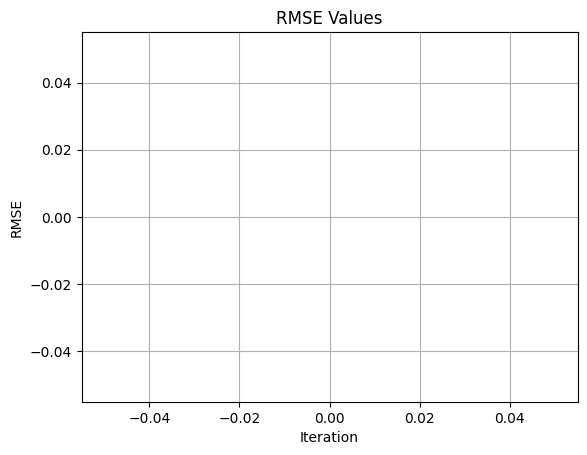

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def mean_squared_error(matches, home_advantage, K, constant):
    """
    Calculate the mean squared error for a given set of matches, home advantage, K value, and constant term.
    """
    squared_errors = []
    ratings = {}  # Reset ratings for each calculation
    for index, match in matches.iterrows():
        home_team, away_team = match['HomeTeam'], match['AwayTeam']
        home_rating, away_rating = ratings.get(home_team, INITIAL_RATING), ratings.get(away_team, INITIAL_RATING)
        home_xG, away_xG = match['Home_xG'], match['Away_xG']
        home_score, away_score = match['HomeScore'], match['AwayScore']
        
        adjusted_home_rating = home_rating + home_advantage
        
        E_home = 1 / (1 + 10 ** ((away_rating - adjusted_home_rating) / constant))
        E_away = 1 - E_home

        # Determine actual score
        S_home, S_away = (1, 0) if home_xG > away_xG else (0, 1) if home_xG < away_xG else (0.5, 0.5)
        
        # Calculate xG difference and adjust K factor
        xG_diff = home_xG - away_xG
        K_adjusted = K * (1 + xG_diff / 2)  # Example adjustment, modify as needed
        
        # Update ratings
        updated_home_rating = home_rating + K_adjusted * (S_home - E_home)
        updated_away_rating = away_rating + K_adjusted * (S_away - E_away)
        
        ratings[home_team] = updated_home_rating
        ratings[away_team] = updated_away_rating
        
        # Calculate squared error
        squared_error_home = (E_home - S_home) ** 2
        squared_error_away = (E_away - S_away) ** 2
        squared_errors.append(squared_error_home + squared_error_away)
    
    return sum(squared_errors) / len(matches)


INITIAL_RATING = 1500

# Define ranges for HOME_ADVANTAGE, K, and the constant term
home_advantage_values = np.arange(150, 200, 1)
K_values = np.arange(0, 20, 0.1)
constant_values = np.arange(350, 500, 1)

best_rmse = float('inf')  # Initialize with a large value
best_home_advantage = None
best_K = None
best_constant = None
RMSE_values = []

for K in K_values:
        # for constant in constant_values:
        mse = mean_squared_error(season_X, 400, K, 2)
        #     RMSE_values.append(mse)
        if mse < best_rmse:
            best_rmse = mse
            best_home_advantage = 400
            best_K = K
            best_constant = 2
#for home_advantage in home_advantage_values:
    

print("Best Home Advantage:", best_home_advantage)
print("Best K:", best_K)
print("Best Constant:", best_constant)

plt.plot(RMSE_values)
plt.title('RMSE Values')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from scipy.stats import norm

def bradley_terry_prob(r_i, r_j, h, c):
    return 1 / (1 + np.exp((r_j - (r_i + h)) / c))

def update_rating(r_i, r_j, xg_diff, s_i, e_i, k, d):

    adjustment = k * (1 + xg_diff / d) * (e_i - s_i)
    return r_i + adjustment

def calculate_rmse(predictions, actuals):
    return np.sqrt(np.mean((predictions - actuals) ** 2))

def optimize_parameters(train_data, initial_params):
    def objective(params):
        h, c, k, d = params
        team_ratings = {team: 1500 for team in train_data['team_1'].unique()}
        predictions = []

        for _, match in train_data.iterrows():
            r_i = team_ratings[match['team_1']]
            r_j = team_ratings[match['team_2']]


            s_i = bradley_terry_prob(r_i, r_j, h, c)
            xg_diff = match['xG_1'] - match['xG_2']
            e_i = match['result']  # 1 for win, 0.5 for draw, 0 for loss

            team_ratings[match['team_1']] = update_rating(r_i, r_j, xg_diff, s_i, e_i, k, d)
            team_ratings[match['team_2']] = update_rating(r_j, r_i, -xg_diff, 1-s_i, 1-e_i, k, d)

            predictions.append(s_i)

        return calculate_rmse(np.array(predictions), train_data['result'].values)

    result = minimize(objective, initial_params, method='Nelder-Mead')
    return result.x

def whole_history_rating(data, params):
    h, c, k, d = params
    team_ratings = {team: 1500 for team in data['team_1'].unique()}

    for _, match in data.iterrows():
        r_i = team_ratings[match['team_1']]
        r_j = team_ratings[match['team_2']]

        # Calculate win probability and update ratings
        s_i = bradley_terry_prob(r_i, r_j, h, c)
        xg_diff = match['xG_1'] - match['xG_2']
        e_i = match['result']  # 1 for win, 0.5 for draw, 0 for loss

        team_ratings[match['team_1']] = update_rating(r_i, r_j, xg_diff, s_i, e_i, k, d)
        team_ratings[match['team_2']] = update_rating(r_j, r_i, -xg_diff, 1-s_i, 1-e_i, k, d)

    return team_ratings
# Sample Usage
if __name__ == "__main__":
    # Example dataset: Replace this with your actual dataset
    data = pd.DataFrame({
        'team_1': ['A', 'B', 'C', 'A', 'B', 'C'],
        'team_2': ['B', 'C', 'A', 'C', 'A', 'B'],
        'xG_1': [1.5, 2.0, 1.2, 1.8, 1.0, 1.6],
        'xG_2': [1.2, 1.8, 1.5, 1.3, 1.6, 1.1],
        'result': [1, 0.5, 0, 1, 0, 0.5]  # 1 for win, 0.5 for draw, 0 for loss
    })

    # Split data into train and test sets
    train_data = data.iloc[:4]
    test_data = data.iloc[4:]

    # Initial parameters: [h, c, k, d]
    initial_params = [30, 400, 16, 2]

    # Optimize parameters
    optimized_params = optimize_parameters(train_data, initial_params)
    print("Optimized Parameters:", optimized_params)

    # Calculate ratings using the whole-history model
    final_ratings = whole_history_rating(data, optimized_params)
    print("Final Team Ratings:", final_ratings)


In [ ]:
import numpy as np
from scipy.optimize import minimize

def elo_expected_score(home_rating, away_rating):

    home_expected_score = 1 / (1 + 10 ** ((away_rating - home_rating) / 400))
    away_expected_score = 1 - home_expected_score
    return home_expected_score, away_expected_score

def update_elo_ratings(home_rating, away_rating, home_xG, away_xG, home_score, away_score, k):
    home_expected_score, away_expected_score = elo_expected_score(home_rating, away_rating)
    
    # Update ratings
    home_new_rating = home_rating + k * (home_score - home_expected_score)
    away_new_rating = away_rating + k * (away_score - away_expected_score)
    
    return home_new_rating, away_new_rating


def calculate_metric(predictions, actual_outcomes):

    # Implement your metric calculation here (e.g., mean squared error)
    # Return the calculated metric
    pass

def fit_elo(params, matches, initial_rating=1500):
    # Unpack parameters
    K, = params
    
    # Initialize ratings dictionary with initial ratings for all teams
    ratings = {team: initial_rating for team in set(matches['HomeTeam']).union(matches['AwayTeam'])}
    
    # Iterate over matches and update ratings
    for index, match in matches.iterrows():
        home_team, away_team = match['HomeTeam'], match['AwayTeam']
        home_xG, away_xG = match['Home_xG'], match['Away_xG']
        home_score, away_score = match['HomeScore'], match['AwayScore']
        
        home_rating, away_rating = ratings[home_team], ratings[away_team]
        
        # Calculate expected scores
        home_expected_score, away_expected_score = elo_expected_score(home_rating, away_rating)
        
        # Determine actual scores
        if home_score > away_score:
            home_score, away_score = 1, 0
        elif home_score < away_score:
            home_score, away_score = 0, 1
        else:
            home_score, away_score = 0.5, 0.5
        
        # Update ratings
        ratings[home_team], ratings[away_team] = update_elo_ratings(home_rating, away_rating, home_xG, away_xG, home_score, away_score, K)
    
    return ratings

def objective_function(params, X_train, y_train, X_val, y_val):

    # Fit Elo ratings using the current K value on the training set
    elo_ratings = fit_elo(params, X_train)
    
    # Predict match outcomes on the validation set
    predictions = predict_elo(elo_ratings, X_val)
    
    # Calculate the evaluation metric
    metric = calculate_metric(predictions, y_val)
    
    return metric

# Initial guess for the K value
initial_k = 32

# Define bounds for K if necessary
# bounds = [(lower_bound, upper_bound)]

# Minimize the objective function
result = minimize(objective_function, initial_k, args=(X_train, y_train, X_val, y_val), method='Nelder-Mead')

# Get the best K value
best_k = result.x[0]

print("Best K value:", best_k)


KeyError: 'HomeTeam'

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assume 'season' DataFrame is previously defined

# Initialize teams and ratings
teams = np.unique(np.concatenate([season['HomeTeam'], season['AwayTeam']]))
ratings = {str(team): 1500 for team in teams}

def mean_squared_error(K, HFA, c, matches):
    squared_errors = []
    for _, match in matches.iterrows():
        home_team = str(match['HomeTeam'])
        away_team = str(match['AwayTeam'])
        home_rating = ratings[home_team]
        away_rating = ratings[away_team]

        adjusted_home_rating = home_rating + HFA
        E_home = 1 / (1 + 10 ** ((away_rating - adjusted_home_rating) / c))
        E_away = 1 - E_home

        home_score = match['HomeScore']
        away_score = match['AwayScore']
        xG_diff = match['Home_xG'] - match['Away_xG']
        K_adjusted = K * (1 + xG_diff / 2)  
        S_home = 1 if home_score > away_score else 0 if home_score < away_score else 0.5
        S_away = 1 - S_home
        updated_home_rating = home_rating + K_adjusted * (S_home - E_home)
        updated_away_rating = away_rating + K_adjusted * (S_away - E_away)
        
        ratings[home_team] = updated_home_rating
        ratings[away_team] = updated_away_rating

        squared_error = ((E_home - S_home) ** 2 + (E_away - S_away) ** 2)
        squared_errors.append(squared_error)

    return np.mean(squared_errors)



In [ ]:
def mean_squared_error(x, K, HFA, c,):
    squared_errors = []
    for _, match in season_X.iterrows():
        home_team = str(match['HomeTeam'])
        away_team = str(match['AwayTeam'])
        home_rating = ratings[home_team]
        away_rating = ratings[away_team]

        x = x - HFA
        E_home = 1 / (1 + 10 ** (x / c))
        E_away = 1 - E_home

        home_score = match['HomeScore']
        away_score = match['AwayScore']
        xG_diff = match['Home_xG'] - match['Away_xG']
        K_adjusted = K * (1 + xG_diff / 2)  
        S_home = 1 if home_score > away_score else 0 if home_score < away_score else 0.5
        S_away = 1 - S_home
        updated_home_rating = home_rating + K_adjusted * (S_home - E_home)
        updated_away_rating = away_rating + K_adjusted * (S_away - E_away)
        
        ratings[home_team] = updated_home_rating
        ratings[away_team] = updated_away_rating

        squared_error = ((E_home - S_home) ** 2 + (E_away - S_away) ** 2)
        squared_errors.append(squared_error)

    return np.mean(squared_errors)
    

In [ ]:
from scipy.optimize import curve_fit

In [37]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize


# Initialize teams and ratings using dictionaries for faster access
teams = np.unique(np.concatenate([season_X['HomeTeam'], season_X['AwayTeam']]))
# home_ratings = np.array([ratings[team] for team in season_X['HomeTeam']])
# away_ratings = np.array([ratings[team] for team in season_X['AwayTeam']])

def mean_squared_error(params, matches):
    K, HFA, c, bCons = params
    # Calculate adjusted home ratings
    adjusted_home_ratings = matches['Home_xG'] + HFA
    
    # Calculate expected outcomes
    E_home = 1 / (1 + 10 ** ((matches['Away_xG'] - adjusted_home_ratings) / c))
    E_away = 1 - E_home
    
    
    S_home = (matches['Home_xG'] > matches['Away_xG']) + 0.5 * (matches['Home_xG'] == matches['Away_xG'])
    S_away = (matches['Away_xG'] > matches['Home_xG']) + 0.5 * (matches['Home_xG'] == matches['Away_xG'])
    

# def mean_squared_error(params, matches):
#     # Calculate squared errors
#     squared_errors = ((E_home - S_home) ** 2 + (E_away - S_away) ** 2)
    
#     # Return mean squared error
#     return np.sqrt(np.mean(squared_errors))



# def mean_squared_error(params, matches):
#     """
#     Calculate the mean squared error for a given set of matches and K value.
#     """
#     squared_errors = []
#     K, HFA, c, bCons = params
#     for index, row in matches.iterrows():
#         match = season.iloc[index]
#         home_team, away_team = match['HomeTeam'], match['AwayTeam']
#         home_rating, away_rating = ratings.get(home_team, INITIAL_RATING), ratings.get(away_team, INITIAL_RATING)
#         home_xG, away_xG = match['Home_xG'], match['Away_xG']
#         home_score, away_score = match['HomeScore'], match['AwayScore']
        
#         adjusted_home_rating = home_rating + params
        
#         E_home = 1 / (1 + 10 ** ((away_rating - adjusted_home_rating) / 400))
#         E_away = 1 - E_home

#         # Determine actual score
#         S_home, S_away = (1, 0) if home_xG > away_xG else (0, 1) if home_xG < away_xG else (0.5, 0.5)
        
#         # Calculate xG difference and adjust K factor
#         xG_diff = home_xG - away_xG
#         K_adjusted = K * (1 + xG_diff / 2)  # Example adjustment, modify as needed
        
#         # Update ratings
#         updated_home_rating = home_rating + K_adjusted * (S_home - E_home)
#         updated_away_rating = away_rating + K_adjusted * (S_away - E_away)
        
#         ratings[home_team] = updated_home_rating
#         ratings[away_team] = updated_away_rating
        
#         # Calculate squared error
#         squared_error_home = (E_home - S_home) ** 2
#         squared_error_away = (E_away - S_away) ** 2
#         squared_errors.append(squared_error_home + squared_error_away)
    
#     return sum(squared_errors) / len(matches)

# INITIAL_RATING = 1500

# Fit the mean squared error function to the data
# p0 = [10, 10, 500, 0]  # Initial guess for K, HFA, and c
# bounds = [(0, None), (0, None), (0, None), (0, None)]
# result = minimize(mean_squared_error, p0, args=(season_X,), bounds=bounds)

# # Extract the optimized values
# best_K, best_HFA, best_c, best_b = result.x
# best_rmse = result.fun

# print("RMSE for best values:", best_rmse)
# print("Best K:", best_K)
# print("Best Home Field Advantage:", best_HFA)
# print("Best c:", best_c)
# print("Best b:", best_b)


In [ ]:
# import numpy as np
# from sklearn.base import BaseEstimator, RegressorMixin
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import make_scorer
# from sklearn.model_selection import train_test_split

# # Define the custom dummy estimator
# class DummyEstimator(BaseEstimator, RegressorMixin):
#     def fit(self, X, y):
#         return self

#     def predict(self, X):
#         return X

# # Wrapper function for mean_squared_error to use with GridSearchCV
# def rmse_scorer(y_true, y_pred):
#     return np.sqrt(mean_squared_error(y_true, y_pred))

# # Define parameter grid
# param_grid = {
#     'K': np.arange(0, 20, 0.1),
#     'HFA': np.arange(0, 200, 1),
#     'c': np.arange(300, 500, 1),
#     'bCons': [True, False]  # Example of binary parameter
# }

# # Instantiate GridSearchCV with your model (here we're using the dummy model)
# grid_search = GridSearchCV(estimator=DummyEstimator(), param_grid=param_grid, scoring=make_scorer(rmse_scorer, greater_is_better=False), cv=5)

# # Split your data into features (X) and target (y)
# X = season_X[['Home_xG', 'Away_xG']]  # Example feature columns
# y = season_X[['HomeScore', 'AwayScore']]  # Example target columns

# # Train-test split (you should adjust this according to your data)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Perform grid search
# grid_search.fit(X_train, y_train)

# # Get the best parameters and RMSE
# best_params = grid_search.best_params_
# best_rmse = np.abs(grid_search.best_score_)  # RMSE is negative in GridSearchCV, so take absolute value

# print("Best parameters:", best_params)
# print("Best RMSE:", best_rmse)


ValueError: Invalid parameter 'HFA' for estimator DummyEstimator(). Valid parameters are: [].

In [ ]:
ratings = {team: 1500 for team in teams}
def update (matches, K, HFA, c):
    adjusted_home_ratings = matches['Home_xG'] + HFA
    
    # Calculate expected outcomes
    E_home = 1 / (1 + 10 ** ((matches['Away_xG'] - adjusted_home_ratings) / c))
    E_away = 1 - E_home
    
    S_home = (matches['Home_xG'] > matches['Away_xG']) + 0.5 * (matches['Home_xG'] == matches['Away_xG'])
    S_away = (matches['Away_xG'] > matches['Home_xG']) + 0.5 * (matches['Home_xG'] == matches['Away_xG'])
    
    xG_diff = matches['Home_xG'] - matches['Away_xG']
    K_adjusted = K * (1 + xG_diff / 500000) 
    updated_home_ratings = adjusted_home_ratings + K_adjusted * (S_home - E_home)
    updated_away_ratings = matches['Away_xG'] + K_adjusted * (S_away - E_away)
    
    for i, team in enumerate(matches['HomeTeam']):
        ratings[team] = updated_home_ratings[i]
    for i, team in enumerate(matches['AwayTeam']):
        ratings[team] = updated_away_ratings[i]

In [ ]:
ratings_forward = {team: 1500 for team in teams}
ratings_reverse = {team: 1500 for team in teams}
ratings = ratings_forward
for index, row in season_y.iterrows():
    update(row,best_K, best_HFA, best_c)

# Update ratings_reverse with the reverse iteration
ratings = ratings_reverse
for index in range(season_y.shape[0] - 1, -1, -1):
    row = season_y.iloc[index]
    update(row, best_K, best_HFA, best_c)

# Create a DataFrame to store both sets of ratings and calculate the difference
ratings_df = pd.DataFrame(index=teams, columns=['EloRating', 'Reverse Rating', 'Difference'])
for team in teams:
    ratings_df.at[team, 'EloRating'] = ratings_forward[team]
    ratings_df.at[team, 'Reverse Rating'] = ratings_reverse[team]
    ratings_df.at[team, 'Difference'] = ratings_forward[team] - ratings_reverse[team]


IndexError: invalid index to scalar variable.

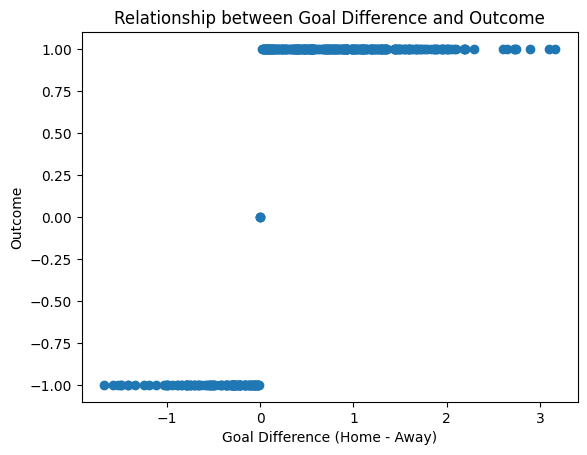

In [ ]:
import matplotlib.pyplot as plt

# Calculate goal difference
season_X['GoalDiff'] = season_X['Home_xG'] - season_X['Away_xG']

# Plot relationship between goal difference and outcome
plt.scatter(season_X['GoalDiff'], season_X['Result'])
plt.xlabel('Goal Difference (Home - Away)')
plt.ylabel('Outcome')
plt.title('Relationship between Goal Difference and Outcome')
plt.show()


In [41]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the range of values for K, HFA, and c
K_values = np.linspace(0, 10, 10)
HFA_values = np.linspace(0, 10, 10)
c_values = np.linspace(300, 600, 10)

# Create meshgrid for the variables
K_mesh, HFA_mesh, c_mesh = np.meshgrid(K_values, HFA_values, c_values, indexing='ij')

# Initialize an array to store the RMSE values
rmses = np.zeros_like(K_mesh)

# Calculate RMSE for each combination of K, HFA, and c
for i in range(len(K_values)):
    for j in range(len(HFA_values)):
        for k in range(len(c_values)):
            rmses[i, j, k] = np.sqrt( mean_squared_error(K_values[i], season[['HomeTeam', 'AwayTeam', 'HomeScore', 'AwayScore', 'Home_xG', 'Away_xG']],))

# Plot 3D surface
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Flatten the arrays
K_flat = K_mesh.flatten()
HFA_flat = HFA_mesh.flatten()
c_flat = c_mesh.flatten()
rmses_flat = rmses.flatten()

# Plot the surface
surf = ax.plot_trisurf(K_flat, HFA_flat, rmses_flat, cmap='viridis')

# Add color bar
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

ax.set_xlabel('K-factor')
ax.set_ylabel('Capabilities weight')
ax.set_zlabel('Breakdown weight')
ax.set_title('RMSE vs K-factor, Capabilities weight, and ')

plt.show()


TypeError: cannot unpack non-iterable numpy.float64 object

In [ ]:
import numpy as np
import pandas as pd

# Assume 'season' DataFrame is previously defined

# Initialize teams and ratings using dictionaries for faster access
teams = np.unique(np.concatenate([season['HomeTeam'], season['AwayTeam']]))
ratings = {team: 1500 for team in teams}
home_ratings = np.array([ratings[team] for team in season['HomeTeam']])
away_ratings = np.array([ratings[team] for team in season['AwayTeam']])

def mean_squared_error(K, HFA, c, matches):
    # Calculate adjusted home ratings
    adjusted_home_ratings = home_ratings + HFA
    
    # Calculate expected outcomes
    E_home = 1 / (1 + 10 ** ((away_ratings - adjusted_home_ratings) / c))
    E_away = 1 - E_home
    
    # Calculate K-factor adjustment based on goal difference
    xG_diff = matches['Home_xG'] - matches['Away_xG']
    K_adjusted = K * (1 + abs( xG_diff) / 2)  
    
    # Determine actual outcomes
    S_home = matches['HomeScore'] > matches['AwayScore']
    S_away = matches['AwayScore'] > matches['HomeScore']
    
    # Update ratings
    updated_home_ratings = home_ratings + K_adjusted * (S_home - E_home)
    updated_away_ratings = away_ratings + K_adjusted * (S_away - E_away)
    
    # Update ratings dictionary
    for i, team in enumerate(matches['HomeTeam']):
        ratings[team] = updated_home_ratings[i]
    for i, team in enumerate(matches['AwayTeam']):
        ratings[team] = updated_away_ratings[i]
    
    # Calculate squared errors
    squared_errors = ((E_home - S_home) ** 2 + (E_away - S_away) ** 2)
    
    # Return mean squared error
    return np.mean(squared_errors)

# Example usage:
# mse = mean_squared_error(K_value, HFA_value, c_value, season)


NameError: name 'season' is not defined